In [28]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix_csr

In [29]:
import liana as li

In [30]:
from matplotlib.pyplot import hist

In [31]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [32]:
counts = pd.read_csv("data/counts_mat.csv")
weights = pd.read_csv("data/weight_mat.csv")

In [33]:
var = pd.DataFrame(counts[['Unnamed: 0']]).set_index('Unnamed: 0')
var.index.name = None

In [34]:
adata = sc.AnnData(X=csr_matrix(counts.drop(counts.columns[0], axis=1), dtype=np.float32).T, var=var)

In [35]:
adata.obsm['proximity'] = csr_matrix(weights)

In [36]:
# scHOT data test
adata = sc.read_h5ad("test_spatial.h5ad")
resource = pd.DataFrame({"ligand":["Dnm1l", "Arrb1", "Igf2", "Dnm1l"], "receptor":["Gucy1b3", "Mtor", "Tuba1a", "Fam63b"]})
dist = adata.obsm['proximity']

In [37]:
# full visium slide
# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

li.mt.get_spatial_proximity(adata=adata, parameter=200, bypass_diagonal=False, cutoff=0.1)
dist = adata.obsm['proximity']

my_p = li.pl.proximity_plot(adata, idx=100)
resource = li.resource.select_resource("mouseconsensus")

In [38]:
temp, lr_res, ligand_pos, receptor_pos = _global_lr_pipe(adata=adata,
                                                         resource=resource,
                                                         expr_prop=0.05,
                                                         use_raw=False,
                                                         verbose=True,
                                                         layer=None,
                                                         _key_cols=['ligand_complex', 'receptor_complex'],
                                                         _complex_cols=['ligand_means', 'receptor_means'],
                                                         _obms_keys=['proximity'],
                                                         resource_name=None
                                                         )

Using `.X`!


In [55]:
n_perm = 100
seed = 0

Correlations

In [39]:
# ligand-receptor mats
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)

Fully-vectorized

In [40]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix_csr

In [41]:
import liana as li

In [69]:
from matplotlib.pyplot import hist
from scipy.stats import spearmanr, pearsonr

In [43]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [44]:
from scipy.stats import rankdata

In [45]:
# ligand-receptor mats
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand).T
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor).T

In [21]:
def calculate_local_correlations(x_mat, y_mat, dist, method="pearson"):
    if method not in ["pearson", "spearman"]:
        raise ValueError("method must be one of 'pearson', 'spearman'")
    
    # transpose
    x_mat, y_mat = x_mat.T, y_mat.T
    
    weight = dist.A.T
    weight_sums = np.sum(weight, axis = 0).flatten()
        
    if method=="spearman":
        x_mat = rankdata(x_mat, axis=1)
        y_mat = rankdata(y_mat, axis=1)
    
    # standard pearson
    n1 = (((x_mat * y_mat).dot(weight)) * weight_sums)
    n2 = (x_mat.dot(weight)) * (y_mat.dot(weight))
    numerator = n1 - n2
    
    denominator_x = (weight_sums * (x_mat ** 2).dot(weight)) - (x_mat.dot(weight))**2
    denominator_y = (weight_sums * (y_mat ** 2).dot(weight)) - (y_mat.dot(weight))**2
    denominator = np.sqrt(denominator_x * denominator_y)
    denominator[denominator == 0] = np.finfo(float).eps # add noise to avoid division by zero
    
    local_corrs = (numerator / denominator)
    
    return local_corrs

In [22]:
dist = adata.obsm['proximity']

In [25]:
local_pc = calculate_local_correlations(x_mat = ligand_mat.A, y_mat=receptor_mat.A, dist=dist, method="pearson")

In [26]:
local_pc

array([[ 0.11775495,  0.        ,  0.07320522, ...,  0.31679758,
         0.08614511,  0.        ],
       [-0.19442862, -0.00572051, -0.10251832, ...,  0.31816354,
        -0.19816568, -0.01154072],
       [-0.14684229, -0.06664198, -0.2709753 , ..., -0.23486906,
         0.11611345,  0.49061623],
       ...,
       [-0.11232401, -0.2953236 , -0.34604046, ...,  0.20728923,
         0.06490986,  0.20051171],
       [ 0.071826  , -0.1637877 ,  0.19777067, ..., -0.11512091,
         0.6614117 ,  0.0007559 ],
       [ 0.        ,  0.21222384,  0.0748205 , ...,  0.16439405,
         0.        ,  0.        ]], dtype=float32)

In [46]:
from liana.method.sp._spatial_utils import _local_permutation_pvals

In [56]:
local_pvals = _local_permutation_pvals(x_mat = ligand_mat.A, 
                                       y_mat = receptor_mat.A, 
                                       local_truth=local_pc,
                                       local_fun=calculate_local_correlations,
                                       dist=dist, 
                                       n_perm=n_perm, 
                                       positive_only=False,
                                       seed=seed)

100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


In [117]:
local_pvals

array([[0.53, 1.  , 0.72, ..., 0.06, 0.69, 1.  ],
       [0.42, 0.96, 0.67, ..., 0.11, 0.3 , 0.93],
       [0.51, 0.69, 0.13, ..., 0.11, 0.52, 0.  ],
       ...,
       [0.66, 0.19, 0.1 , ..., 0.31, 0.85, 0.5 ],
       [0.71, 0.59, 0.33, ..., 0.32, 0.  , 1.  ],
       [1.  , 0.33, 0.69, ..., 0.14, 1.  , 1.  ]])

In [57]:
local_sp = calculate_local_correlations(x_mat = ligand_mat.A, y_mat=receptor_mat.A, dist=dist, method="spearman")

In [60]:
local_sp_pvals = _local_permutation_pvals(x_mat = ligand_mat.A, 
                                          y_mat = receptor_mat.A, 
                                          local_truth=local_sp,
                                          local_fun=calculate_local_correlations,
                                          dist=dist, 
                                          n_perm=n_perm, 
                                          positive_only=False,
                                          seed=seed,
                                          method="spearman"
                                          )

100%|██████████| 100/100 [05:23<00:00,  3.23s/it]


In [63]:
local_pvals.shape

(1409, 2688)

In [64]:
local_sp_pvals.shape

(1409, 2688)

In [73]:
spearmanr(local_sp_pvals[1,:], local_pvals[1,:])

SpearmanrResult(correlation=0.9086609733687256, pvalue=0.0)

Global summary of the local scores:

In [97]:
lr_res.loc[:,['pearson_mean','pearson_sd']] = np.vstack([np.mean(local_pc, axis=1), np.std(local_pc, axis=1)]).T

In [99]:
lr_res.sort_values(by='pearson_mean', ascending=False)

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min,pearson_mean,pearson_sd
752,App&Aplp1,App,Aplp1,App,Aplp1,3.040105,0.998140,3.126448,0.999628,0.998140,0.313378,0.239281
1720,Nptx1&Nptxr,Nptx1,Nptxr,Nptx1,Nptxr,1.045611,0.723586,1.783589,0.889509,0.723586,0.179267,0.251400
1687,Rtn4&Lingo1,Rtn4,Lingo1,Rtn4,Lingo1,2.446542,0.992188,1.553612,0.893601,0.893601,0.169330,0.251384
1222,Sema4d&Plxnb3,Sema4d,Plxnb3,Sema4d,Plxnb3,0.544131,0.524554,0.190867,0.219866,0.219866,0.166959,0.248774
550,App&Aplp2,App,Aplp2,App,Aplp2,3.040105,0.998140,2.031858,0.985119,0.985119,0.162170,0.223698
...,...,...,...,...,...,...,...,...,...,...,...,...
1034,L1cam&Ptprz1,L1cam,Ptprz1,L1cam,Ptprz1,0.788955,0.692708,1.292046,0.919643,0.692708,-0.101769,0.213972
1102,L1cam&Cd9,L1cam,Cd9,L1cam,Cd9,0.788955,0.692708,0.870121,0.682292,0.682292,-0.102461,0.242683
1551,Apoe&Chrna4,Apoe,Chrna4,Apoe,Chrna4,4.075930,1.000000,0.445172,0.465774,0.465774,-0.116608,0.223021
1679,Psap&Gpr37l1,Psap,Gpr37l1,Psap,Gpr37l1,3.318095,0.999628,1.765455,0.977307,0.977307,-0.120717,0.229645


masked

In [119]:
# ligand-receptor mats
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)

In [120]:
import scipy.stats as stats

In [130]:
def masked_wcor(x, y, weight, method='spearman_nzw'):
    spot_n = x.shape[0]
    
    # reshape x and y to be the same shape as weight
    x = np.reshape(np.repeat(x, spot_n), newshape=(spot_n, spot_n)).T
    y = np.reshape(np.repeat(y, spot_n), newshape=(spot_n, spot_n)).T
    
    # mask x and y with the same mask as weight
    x_masked = np.ma.array(x, mask = weight.mask, fill_value=np.nan)
    y_masked = np.ma.array(y, mask = weight.mask, fill_value=np.nan)
    
    if method == 'spearman_nzw':
        x_masked = stats.mstats.rankdata(x_masked, axis=1)
        y_masked = stats.mstats.rankdata(y_masked, axis=1)
        
    
    # calculate weighted pearson correlation
    wsum = np.ma.sum(weight, axis=1)
    xws = np.ma.sum(weight * x_masked, axis=1)
    yws = np.ma.sum(weight * y_masked, axis=1)
    
    n1 = wsum * np.ma.sum(weight * x_masked * y_masked, axis=1)
    n2 = xws * yws
    numerator = n1 - n2
    
    denominator_x = wsum * np.ma.sum(weight * (x_masked**2), axis=1) - xws**2
    denominator_y = wsum * np.ma.sum(weight * (y_masked**2), axis=1) - yws**2
    wcor = numerator / np.ma.sqrt(denominator_x * denominator_y)
    
    return wcor.data

In [134]:
def calculate_masked_correlations(x_mat, y_mat, dist, method='spearman_nzw'):
    weight = dist.A
    msk = np.logical_not(weight>0).astype(np.int16)
    weight = np.ma.masked_array(weight, mask=msk)
    # calculate for each x and y combination
    local_correlations = []
    
    for i in range(x_mat.shape[0]):
        local_correlations.append(masked_wcor(x_mat[i, :], y_mat[i, :], weight=weight))
    local_correlations = np.array(local_correlations)
    
    return local_correlations


In [135]:
ligand_mat.shape

(1409, 2688)

In [136]:
%%time

dist = adata.obsm['proximity']

masked_sp = calculate_masked_correlations(ligand_mat[0:10,:].A, receptor_mat[0:10,:].A, dist=dist, method='spearman_nzw')

CPU times: user 21.1 s, sys: 7.98 s, total: 29.1 s
Wall time: 29.3 s


In [137]:
masked_sp[0:10,0:10]

array([[ 0.12049729,  0.        ,  0.11016797, -0.20608103,  0.21943871,
        -0.11546491,  0.25134708, -0.17371267,  0.19082757, -0.10393814],
       [-0.15209161, -0.04359862, -0.14015451, -0.49015079, -0.0669737 ,
        -0.07049859, -0.16523511, -0.39150574,  0.14699451, -0.13722149],
       [-0.16374455, -0.0682216 , -0.28411074, -0.19172075,  0.25262793,
         0.3837503 ,  0.14866258, -0.02761892,  0.28759654, -0.11783624],
       [-0.09075614, -0.09892519, -0.14883346,  0.34355083,  0.3604052 ,
         0.37844732,  0.06048634,  0.13773981,  0.15850836, -0.14208299],
       [-0.20395358, -0.05371625, -0.16289518,  0.        ,  0.06958576,
         0.13323865,  0.09405656, -0.08858841, -0.01459214, -0.05856382],
       [ 0.06149178, -0.34234225, -0.03447092, -0.10714982, -0.44833954,
         0.03704983,  0.01411414,  0.0226737 ,  0.15963833, -0.17996375],
       [ 0.13048961, -0.22678031, -0.03650709,  0.32043352, -0.12093551,
         0.02076594,  0.15750812,  0.29120851

(array([ 15.,  69., 445., 818., 676., 246., 221., 135.,  49.,  14.]),
 array([-0.48527399, -0.37078336, -0.25629273, -0.1418021 , -0.02731147,
         0.08717916,  0.20166979,  0.31616042,  0.43065105,  0.54514168,
         0.65963231]),
 <BarContainer object of 10 artists>)

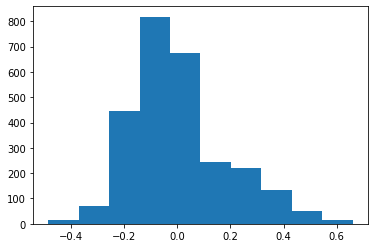

In [129]:
hist(masked_sp[0,:])

In [158]:
spot_n = x.shape[1]

In [159]:
weight = dist.A
msk = np.logical_not(weight>0).astype(np.int16)
weight = np.ma.masked_array(weight, mask=msk)

In [160]:
x, y = ligand_mat[0,:].A, receptor_mat[0,:].A

In [161]:
spot_n


2688

In [162]:
# reshape x and y to be the same shape as weight
x = np.reshape(np.repeat(x, spot_n), newshape=(spot_n, spot_n)).T
y = np.reshape(np.repeat(y, spot_n), newshape=(spot_n, spot_n)).T

In [167]:
# mask x and y with the same mask as weight
x_masked = np.ma.array(x, mask = weight.mask, fill_value=np.nan)
y_masked = np.ma.array(y, mask = weight.mask, fill_value=np.nan)

In [164]:
x_masked = stats.mstats.rankdata(x_masked, axis=1)
y_masked = stats.mstats.rankdata(y_masked, axis=1)

local p-values

In [ ]:
from numpy import random
from tqdm import tqdm

In [ ]:
rng = random.default_rng(0)
n_perm = 100
positive_only = True # remove this option?

In [ ]:
dist = adata.obsm['proximity']

In [ ]:
local_pc.shape

In [ ]:
def _get_local_permutation_pvals(x_mat, y_mat, local_truth, local_fun, dist, n_perm, positive_only=True, **kwargs):
    xy_n = local_truth.shape[0]
    spot_n = local_truth.shape[1]
    
    print(spot_n)
    
    # permutation cubes to be populated
    local_pvals = np.zeros((xy_n, spot_n))
    
    # shuffle the matrix
    for i in tqdm(range(n_perm)):
        _idx = rng.permutation(spot_n)
        perm_score = local_fun(x_mat = x_mat[_idx, :], y_mat=y_mat, dist=dist, **kwargs) ## TODO switch to shuffle rows, not columns
        if positive_only:
            local_pvals += np.array(perm_score >= local_truth, dtype=int)
        else:
            local_pvals += (np.array(np.abs(perm_score) >= np.abs(local_truth), dtype=int))

    local_pvals = local_pvals / n_perm
    
    return local_pvals
    

In [ ]:
from liana.method.sp._spatial_utils import _local_permutation_pvals

In [ ]:
local_pvals = _local_permutation_pvals(x_mat = ligand_mat.A, 
                                       y_mat = receptor_mat.A, 
                                       local_truth=local_pc,
                                       local_fun=calculate_local_correlations,
                                       dist=dist, 
                                       n_perm=n_perm, 
                                       positive_only=False,
                                       seed=0)

In [ ]:
local_pvals

In [ ]:
local_pvals

In [ ]:
from  scipy.sparse import csr_matrix

In [ ]:
local_pvals.shape

In [ ]:
local_pvals

In [ ]:
local_pc.shape

In [ ]:
local_pvals.shape

In [ ]:
local_masked_pvals = _get_local_permutation_pvals(x_mat = ligand_mat.A,
                                                  y_mat = receptor_mat.A,
                                                  local_truth = masked_sp,
                                                  local_fun=calculate_masked_correlations,
                                                  dist=dist,
                                                  n_perm=n_perm,
                                                  positive_only=False)

In [ ]:
local_masked_pvals

In [ ]:
local_masked_pvals.shape

In [ ]:
from scipy.stats import spearmanr,  pearsonr

In [ ]:
pearsonr(local_masked_pvals[0,:], local_pvals[0,:])